In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat
from numpy import ndarray
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# fungsi untuk merubah data menjadi supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')

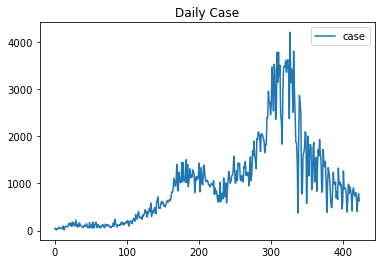

In [4]:
case.plot()
plt.title("Daily Case")
plt.show()

In [5]:
new_date = case[['date']]

In [6]:
case['date'] = case['date'].astype('datetime64[ns]')
case.set_index('date', inplace=True)
case.head()

,case
date,
2020-03-18,38
2020-03-19,50
2020-03-20,14
2020-03-21,44
2020-03-22,36


In [7]:
# seasonal decomposition untuk memisahkan data
decompose = seasonal_decompose(case, model='additive', extrapolate_trend='freq')

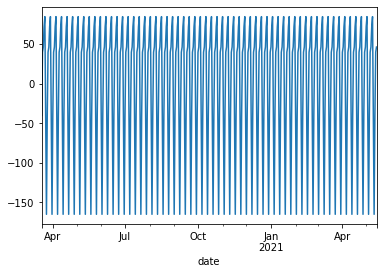

In [8]:
decompose.seasonal.plot()
plt.show()

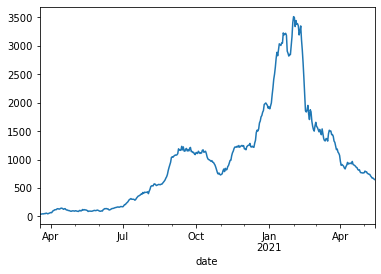

In [9]:
decompose.trend.plot()
plt.show()

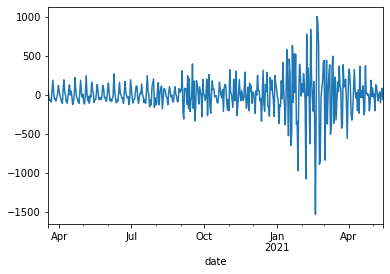

In [10]:
decompose.resid.plot()
plt.show()

In [11]:
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
actual = decompose.observed

In [12]:
new_trend = trend.to_frame()
new_seasonal = seasonal.to_frame()
new_residual = residual.to_frame()
new_actual = actual.to_frame()

In [13]:
# Ambil data untuk evaluasi
data_evaluasi = case[413:]

#total split data untuk LSTM
n_total = 412

# Split data ARIMA
train_ARIMA = new_trend[:412]
test_ARIMA = new_trend[412:]

#jumlah neuron
neu = int(2/3*(n_total+1))
neuron_seasonal = neu
neuron_residual = neu

# Parameter untuk LSTM
epooch_seasonal = 1000
epooch_residual = 1500
size_batch = 5

In [14]:
new_seasonal.reset_index(drop=True, inplace=True)
seasonal_data = pd.concat([new_date, new_seasonal], axis=1)
seasonal_data.set_index('date', inplace=True)

new_residual.reset_index(drop=True, inplace=True)
residual_data = pd.concat([new_date, new_residual], axis=1)
residual_data.set_index('date', inplace=True)

data_seasonal = seasonal_data

data_residual = residual_data

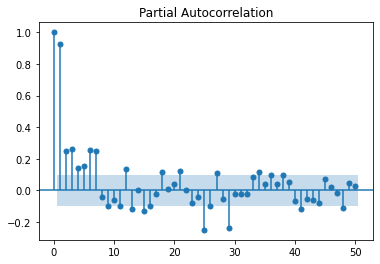

In [15]:
plot_pacf(case, lags=50)
plt.show()

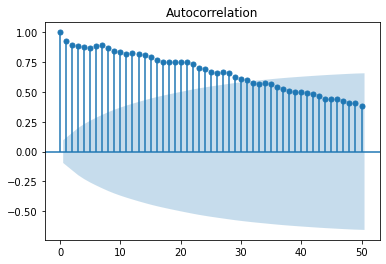

In [16]:
plot_acf(case, lags=50)
plt.show()

In [17]:
model = ARIMA(train_ARIMA, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

C:\ProgramData\Anaconda3\envs\fc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\fc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\fc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  412
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2219.098
Date:                Sat, 18 Sep 2021   AIC                           4446.196
Time:                        13:58:25   BIC                           4462.280
Sample:                    03-18-2020   HQIC                          4452.558
                         - 05-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        997.2684    582.692      1.711      0.087    -144.787    2139.324
ar.L1          0.9962      0.002    400.447      0.000       0.991       1.001
ma.L1          0.3396      0.029     11.692      0.0

In [18]:
hasil = model_fit.forecast(10)
hasil= hasil.to_frame()

In [19]:
# ubah data menjadi supervised learning problem
reframed_seasonal = series_to_supervised(data_seasonal, 1, 1)
reframed_residual = series_to_supervised(data_residual, 1, 1)

In [20]:
# split data menjadi data train dan test
values_seasonal= reframed_seasonal.values
values_residual= reframed_residual.values

train_seasonal = values_seasonal[:n_total, :]
test_seasonal = values_seasonal[n_total:, :]

train_residual = values_residual[:n_total, :]
test_residual = values_residual[n_total:, :]

# split menjadi input dan output
seasonal_train_X, seasonal_train_y = train_seasonal[:, :-1], train_seasonal[:, -1]
seasonal_test_X, seasonal_test_y = test_seasonal[:, :-1], test_seasonal[:, -1]

residual_train_X, residual_train_y = train_residual[:, :-1], train_residual[:, -1]
residual_test_X, residual_test_y = test_residual[:, :-1], test_residual[:, -1]

# reshape input menjadi [samples, timesteps, features]
seasonal_train_X = seasonal_train_X.reshape((seasonal_train_X.shape[0], 1, seasonal_train_X.shape[1]))
seasonal_test_X = seasonal_test_X.reshape((seasonal_test_X.shape[0], 1, seasonal_test_X.shape[1]))

residual_train_X = residual_train_X.reshape((residual_train_X.shape[0], 1, residual_train_X.shape[1]))
residual_test_X = residual_test_X.reshape((residual_test_X.shape[0], 1, residual_test_X.shape[1]))


#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Epoch 1/1000
83/83 - 1s - loss: 67.2809 - val_loss: 56.7603
Epoch 2/1000
83/83 - 0s - loss: 63.0284 - val_loss: 52.1022
Epoch 3/1000
83/83 - 0s - loss: 58.4393 - val_loss: 47.4140
Epoch 4/1000
83/83 - 0s - loss: 54.1462 - val_loss: 44.0808
Epoch 5/1000
83/83 - 0s - loss: 52.3362 - val_loss: 43.4375
Epoch 6/1000
83/83 - 0s - loss: 51.4845 - val_loss: 42.7719
Epoch 7/1000
83/83 - 0s - loss: 50.6854 - val_loss: 42.2648
Epoch 8/1000
83/83 - 0s - loss: 50.3593 - val_loss: 42.0929
Epoch 9/1000
83/83 - 0s - loss: 50.2207 - val_loss: 41.9730
Epoch 10/1000
83/83 - 0s - loss: 50.1490 - val_loss: 42.0403
Epoch 11/1000
83/83 - 0s - loss: 50.1010 - val_loss: 42.0068
Epoch 12/1000
83/83 - 0s - loss: 50.0670 - val_loss: 42.2037
Epoch 13/1000
83/83 - 0s - loss: 50.0241 - val_loss: 42.0545
Epoch 14/1000
83/83 - 0s - loss: 49.9919 - val_loss: 42.0061
Epoch 15/1000
83/83 - 0s - loss: 49.9552 - val_loss: 42.0748
Epoch 16/1000
83/83 - 0s - loss: 49.9701 - val_loss: 41.9817
Epoch 17/1000
83/83 - 0s - loss: 

Epoch 135/1000
83/83 - 0s - loss: 45.4721 - val_loss: 41.5515
Epoch 136/1000
83/83 - 0s - loss: 45.3978 - val_loss: 41.7012
Epoch 137/1000
83/83 - 0s - loss: 45.3140 - val_loss: 41.3684
Epoch 138/1000
83/83 - 0s - loss: 45.3144 - val_loss: 41.9979
Epoch 139/1000
83/83 - 0s - loss: 45.2890 - val_loss: 41.3891
Epoch 140/1000
83/83 - 0s - loss: 45.2938 - val_loss: 41.7131
Epoch 141/1000
83/83 - 0s - loss: 45.3269 - val_loss: 41.4851
Epoch 142/1000
83/83 - 0s - loss: 45.2080 - val_loss: 41.8425
Epoch 143/1000
83/83 - 0s - loss: 45.2150 - val_loss: 41.6651
Epoch 144/1000
83/83 - 0s - loss: 45.1879 - val_loss: 41.6587
Epoch 145/1000
83/83 - 0s - loss: 45.1780 - val_loss: 41.5213
Epoch 146/1000
83/83 - 0s - loss: 45.1980 - val_loss: 41.7340
Epoch 147/1000
83/83 - 0s - loss: 45.1414 - val_loss: 41.4627
Epoch 148/1000
83/83 - 0s - loss: 45.0987 - val_loss: 41.9983
Epoch 149/1000
83/83 - 0s - loss: 45.1761 - val_loss: 41.9037
Epoch 150/1000
83/83 - 0s - loss: 45.0403 - val_loss: 41.7109
Epoch 15

83/83 - 0s - loss: 42.0001 - val_loss: 42.7216
Epoch 268/1000
83/83 - 0s - loss: 41.9872 - val_loss: 42.7394
Epoch 269/1000
83/83 - 0s - loss: 41.9312 - val_loss: 42.5575
Epoch 270/1000
83/83 - 0s - loss: 41.9953 - val_loss: 43.7424
Epoch 271/1000
83/83 - 0s - loss: 41.8938 - val_loss: 42.8902
Epoch 272/1000
83/83 - 0s - loss: 41.8844 - val_loss: 43.1503
Epoch 273/1000
83/83 - 0s - loss: 41.8761 - val_loss: 42.9023
Epoch 274/1000
83/83 - 0s - loss: 41.8634 - val_loss: 43.1619
Epoch 275/1000
83/83 - 0s - loss: 41.8404 - val_loss: 42.7955
Epoch 276/1000
83/83 - 0s - loss: 41.7217 - val_loss: 43.0034
Epoch 277/1000
83/83 - 0s - loss: 41.7132 - val_loss: 42.6744
Epoch 278/1000
83/83 - 0s - loss: 41.6209 - val_loss: 42.9455
Epoch 279/1000
83/83 - 0s - loss: 41.6314 - val_loss: 42.7332
Epoch 280/1000
83/83 - 0s - loss: 41.5745 - val_loss: 42.6749
Epoch 281/1000
83/83 - 0s - loss: 41.5165 - val_loss: 43.1052
Epoch 282/1000
83/83 - 0s - loss: 41.5701 - val_loss: 42.6287
Epoch 283/1000
83/83 - 

Epoch 400/1000
83/83 - 0s - loss: 36.9229 - val_loss: 42.6864
Epoch 401/1000
83/83 - 0s - loss: 36.8001 - val_loss: 42.8407
Epoch 402/1000
83/83 - 0s - loss: 36.7742 - val_loss: 42.8674
Epoch 403/1000
83/83 - 0s - loss: 36.6727 - val_loss: 42.9613
Epoch 404/1000
83/83 - 0s - loss: 36.5915 - val_loss: 42.6107
Epoch 405/1000
83/83 - 0s - loss: 36.5711 - val_loss: 42.7087
Epoch 406/1000
83/83 - 0s - loss: 36.5375 - val_loss: 43.0722
Epoch 407/1000
83/83 - 0s - loss: 36.6814 - val_loss: 42.9391
Epoch 408/1000
83/83 - 0s - loss: 36.4071 - val_loss: 42.8820
Epoch 409/1000
83/83 - 0s - loss: 36.3888 - val_loss: 43.0800
Epoch 410/1000
83/83 - 0s - loss: 36.3192 - val_loss: 42.6443
Epoch 411/1000
83/83 - 0s - loss: 36.3513 - val_loss: 42.6947
Epoch 412/1000
83/83 - 0s - loss: 36.2619 - val_loss: 42.6704
Epoch 413/1000
83/83 - 0s - loss: 36.2829 - val_loss: 42.6756
Epoch 414/1000
83/83 - 0s - loss: 36.1457 - val_loss: 42.6020
Epoch 415/1000
83/83 - 0s - loss: 36.0611 - val_loss: 42.6821
Epoch 41

83/83 - 0s - loss: 30.1889 - val_loss: 38.6329
Epoch 533/1000
83/83 - 0s - loss: 30.1015 - val_loss: 38.6908
Epoch 534/1000
83/83 - 0s - loss: 30.0691 - val_loss: 38.7699
Epoch 535/1000
83/83 - 0s - loss: 30.0555 - val_loss: 38.5702
Epoch 536/1000
83/83 - 0s - loss: 30.0773 - val_loss: 38.2866
Epoch 537/1000
83/83 - 0s - loss: 29.9640 - val_loss: 38.3110
Epoch 538/1000
83/83 - 0s - loss: 29.7934 - val_loss: 38.4027
Epoch 539/1000
83/83 - 0s - loss: 29.8370 - val_loss: 38.3768
Epoch 540/1000
83/83 - 0s - loss: 29.8060 - val_loss: 38.6307
Epoch 541/1000
83/83 - 0s - loss: 29.8031 - val_loss: 37.9392
Epoch 542/1000
83/83 - 0s - loss: 29.6392 - val_loss: 38.9649
Epoch 543/1000
83/83 - 0s - loss: 29.5098 - val_loss: 37.9321
Epoch 544/1000
83/83 - 0s - loss: 29.5196 - val_loss: 37.7885
Epoch 545/1000
83/83 - 0s - loss: 29.5808 - val_loss: 38.1350
Epoch 546/1000
83/83 - 0s - loss: 29.3916 - val_loss: 37.9694
Epoch 547/1000
83/83 - 0s - loss: 29.1860 - val_loss: 38.0906
Epoch 548/1000
83/83 - 

Epoch 665/1000
83/83 - 0s - loss: 24.9924 - val_loss: 33.8658
Epoch 666/1000
83/83 - 0s - loss: 24.9447 - val_loss: 34.1162
Epoch 667/1000
83/83 - 0s - loss: 24.8586 - val_loss: 34.2911
Epoch 668/1000
83/83 - 0s - loss: 24.7954 - val_loss: 34.2177
Epoch 669/1000
83/83 - 0s - loss: 24.7943 - val_loss: 33.9093
Epoch 670/1000
83/83 - 0s - loss: 24.7530 - val_loss: 34.0432
Epoch 671/1000
83/83 - 0s - loss: 25.4275 - val_loss: 33.9594
Epoch 672/1000
83/83 - 0s - loss: 25.4258 - val_loss: 34.2662
Epoch 673/1000
83/83 - 0s - loss: 25.1607 - val_loss: 33.8785
Epoch 674/1000
83/83 - 0s - loss: 24.9089 - val_loss: 34.5230
Epoch 675/1000
83/83 - 0s - loss: 25.1320 - val_loss: 34.8900
Epoch 676/1000
83/83 - 0s - loss: 24.9278 - val_loss: 34.0088
Epoch 677/1000
83/83 - 0s - loss: 24.8459 - val_loss: 34.4756
Epoch 678/1000
83/83 - 0s - loss: 24.6089 - val_loss: 33.5599
Epoch 679/1000
83/83 - 0s - loss: 24.7178 - val_loss: 33.4832
Epoch 680/1000
83/83 - 0s - loss: 24.6634 - val_loss: 33.4909
Epoch 68

83/83 - 0s - loss: 24.1275 - val_loss: 33.7654
Epoch 798/1000
83/83 - 0s - loss: 24.3137 - val_loss: 32.8070
Epoch 799/1000
83/83 - 0s - loss: 24.1846 - val_loss: 33.1933
Epoch 800/1000
83/83 - 0s - loss: 24.0746 - val_loss: 32.8791
Epoch 801/1000
83/83 - 0s - loss: 24.0908 - val_loss: 33.3326
Epoch 802/1000
83/83 - 0s - loss: 24.1802 - val_loss: 32.5795
Epoch 803/1000
83/83 - 0s - loss: 24.1151 - val_loss: 33.1182
Epoch 804/1000
83/83 - 0s - loss: 24.0989 - val_loss: 33.4458
Epoch 805/1000
83/83 - 0s - loss: 24.0531 - val_loss: 33.5532
Epoch 806/1000
83/83 - 0s - loss: 24.3684 - val_loss: 33.0663
Epoch 807/1000
83/83 - 0s - loss: 24.4215 - val_loss: 33.3631
Epoch 808/1000
83/83 - 0s - loss: 24.4067 - val_loss: 33.0770
Epoch 809/1000
83/83 - 0s - loss: 23.9884 - val_loss: 33.0072
Epoch 810/1000
83/83 - 0s - loss: 24.3456 - val_loss: 32.7964
Epoch 811/1000
83/83 - 0s - loss: 24.0940 - val_loss: 33.2173
Epoch 812/1000
83/83 - 0s - loss: 24.4439 - val_loss: 32.8387
Epoch 813/1000
83/83 - 

Epoch 930/1000
83/83 - 0s - loss: 23.8409 - val_loss: 31.9769
Epoch 931/1000
83/83 - 0s - loss: 23.5708 - val_loss: 32.8688
Epoch 932/1000
83/83 - 0s - loss: 23.7144 - val_loss: 32.2508
Epoch 933/1000
83/83 - 0s - loss: 23.4995 - val_loss: 32.1551
Epoch 934/1000
83/83 - 0s - loss: 23.4871 - val_loss: 32.4041
Epoch 935/1000
83/83 - 0s - loss: 23.6403 - val_loss: 32.8346
Epoch 936/1000
83/83 - 0s - loss: 23.6229 - val_loss: 32.5298
Epoch 937/1000
83/83 - 0s - loss: 23.6938 - val_loss: 31.9767
Epoch 938/1000
83/83 - 0s - loss: 23.6729 - val_loss: 32.3191
Epoch 939/1000
83/83 - 0s - loss: 23.6558 - val_loss: 32.1287
Epoch 940/1000
83/83 - 0s - loss: 23.4672 - val_loss: 32.3452
Epoch 941/1000
83/83 - 0s - loss: 23.4660 - val_loss: 32.0686
Epoch 942/1000
83/83 - 0s - loss: 23.6208 - val_loss: 32.2409
Epoch 943/1000
83/83 - 0s - loss: 23.5073 - val_loss: 32.0327
Epoch 944/1000
83/83 - 0s - loss: 23.8845 - val_loss: 32.3750
Epoch 945/1000
83/83 - 0s - loss: 23.6311 - val_loss: 32.1358
Epoch 94

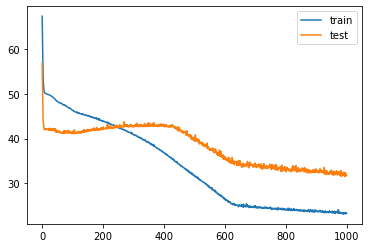

In [21]:
# LSTM model untuk seasonal
model1 = Sequential()
model1.add(LSTM(neuron_seasonal, input_shape=(seasonal_train_X.shape[1], seasonal_train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(seasonal_train_X, seasonal_train_y, epochs=epooch_seasonal, batch_size=size_batch, validation_data=(seasonal_test_X, seasonal_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
# make a prediction
yhat_seasonality = model1.predict(seasonal_test_X)
yhat_seasonality

array([[ -40.12747 ],
       [-118.70036 ],
       [  46.081017],
       [  71.70355 ],
       [  83.94177 ],
       [ -37.115654],
       [-165.49432 ],
       [ -40.12747 ],
       [-118.70036 ],
       [  46.081017]], dtype=float32)

Epoch 1/1500
83/83 - 1s - loss: 151.6559 - val_loss: 66.0475
Epoch 2/1500
83/83 - 0s - loss: 151.3156 - val_loss: 66.7227
Epoch 3/1500
83/83 - 0s - loss: 151.0979 - val_loss: 67.4087
Epoch 4/1500
83/83 - 0s - loss: 150.9024 - val_loss: 67.8597
Epoch 5/1500
83/83 - 0s - loss: 150.7468 - val_loss: 68.2759
Epoch 6/1500
83/83 - 0s - loss: 150.6092 - val_loss: 68.6640
Epoch 7/1500
83/83 - 0s - loss: 150.4760 - val_loss: 69.0288
Epoch 8/1500
83/83 - 0s - loss: 150.3601 - val_loss: 69.3324
Epoch 9/1500
83/83 - 0s - loss: 150.2860 - val_loss: 69.6289
Epoch 10/1500
83/83 - 0s - loss: 150.2223 - val_loss: 69.8754
Epoch 11/1500
83/83 - 0s - loss: 150.1616 - val_loss: 70.1168
Epoch 12/1500
83/83 - 0s - loss: 150.0982 - val_loss: 70.2917
Epoch 13/1500
83/83 - 0s - loss: 150.0427 - val_loss: 70.4918
Epoch 14/1500
83/83 - 0s - loss: 149.9888 - val_loss: 70.6970
Epoch 15/1500
83/83 - 0s - loss: 149.9368 - val_loss: 70.8869
Epoch 16/1500
83/83 - 0s - loss: 149.8738 - val_loss: 71.0701
Epoch 17/1500
83/

Epoch 133/1500
83/83 - 0s - loss: 149.2637 - val_loss: 73.5239
Epoch 134/1500
83/83 - 0s - loss: 149.2614 - val_loss: 73.5156
Epoch 135/1500
83/83 - 0s - loss: 149.2692 - val_loss: 73.5193
Epoch 136/1500
83/83 - 0s - loss: 149.2605 - val_loss: 73.5179
Epoch 137/1500
83/83 - 0s - loss: 149.2575 - val_loss: 73.5084
Epoch 138/1500
83/83 - 0s - loss: 149.2565 - val_loss: 73.5100
Epoch 139/1500
83/83 - 0s - loss: 149.2544 - val_loss: 73.5019
Epoch 140/1500
83/83 - 0s - loss: 149.2620 - val_loss: 73.5072
Epoch 141/1500
83/83 - 0s - loss: 149.2536 - val_loss: 73.5060
Epoch 142/1500
83/83 - 0s - loss: 149.2506 - val_loss: 73.4968
Epoch 143/1500
83/83 - 0s - loss: 149.2497 - val_loss: 73.4987
Epoch 144/1500
83/83 - 0s - loss: 149.2476 - val_loss: 73.4910
Epoch 145/1500
83/83 - 0s - loss: 149.2464 - val_loss: 73.4931
Epoch 146/1500
83/83 - 0s - loss: 149.2446 - val_loss: 73.4855
Epoch 147/1500
83/83 - 0s - loss: 149.2429 - val_loss: 73.4757
Epoch 148/1500
83/83 - 0s - loss: 149.2419 - val_loss: 

83/83 - 0s - loss: 149.0846 - val_loss: 73.0797
Epoch 264/1500
83/83 - 0s - loss: 149.0694 - val_loss: 73.0319
Epoch 265/1500
83/83 - 0s - loss: 149.0741 - val_loss: 73.0455
Epoch 266/1500
83/83 - 0s - loss: 149.0811 - val_loss: 73.0648
Epoch 267/1500
83/83 - 0s - loss: 149.0660 - val_loss: 73.0172
Epoch 268/1500
83/83 - 0s - loss: 149.0713 - val_loss: 73.0424
Epoch 269/1500
83/83 - 0s - loss: 149.0779 - val_loss: 73.0650
Epoch 270/1500
83/83 - 0s - loss: 149.0549 - val_loss: 73.0064
Epoch 271/1500
83/83 - 0s - loss: 149.0776 - val_loss: 73.0341
Epoch 272/1500
83/83 - 0s - loss: 149.0612 - val_loss: 72.9911
Epoch 273/1500
83/83 - 0s - loss: 149.0742 - val_loss: 73.0199
Epoch 274/1500
83/83 - 0s - loss: 149.0506 - val_loss: 72.9670
Epoch 275/1500
83/83 - 0s - loss: 149.0738 - val_loss: 72.9990
Epoch 276/1500
83/83 - 0s - loss: 149.0570 - val_loss: 72.9586
Epoch 277/1500
83/83 - 0s - loss: 149.0702 - val_loss: 72.9897
Epoch 278/1500
83/83 - 0s - loss: 149.0464 - val_loss: 72.9384
Epoch 2

Epoch 394/1500
83/83 - 0s - loss: 148.9427 - val_loss: 72.6502
Epoch 395/1500
83/83 - 0s - loss: 148.9422 - val_loss: 72.6271
Epoch 396/1500
83/83 - 0s - loss: 148.9539 - val_loss: 72.6872
Epoch 397/1500
83/83 - 0s - loss: 148.9395 - val_loss: 72.6564
Epoch 398/1500
83/83 - 0s - loss: 148.9379 - val_loss: 72.6174
Epoch 399/1500
83/83 - 0s - loss: 148.9385 - val_loss: 72.6001
Epoch 400/1500
83/83 - 0s - loss: 148.9508 - val_loss: 72.6652
Epoch 401/1500
83/83 - 0s - loss: 148.9319 - val_loss: 72.6376
Epoch 402/1500
83/83 - 0s - loss: 148.9518 - val_loss: 72.6959
Epoch 403/1500
83/83 - 0s - loss: 148.9295 - val_loss: 72.6626
Epoch 404/1500
83/83 - 0s - loss: 148.9337 - val_loss: 72.6389
Epoch 405/1500
83/83 - 0s - loss: 148.9440 - val_loss: 72.6838
Epoch 406/1500
83/83 - 0s - loss: 148.9312 - val_loss: 72.6537
Epoch 407/1500
83/83 - 0s - loss: 148.9307 - val_loss: 72.6309
Epoch 408/1500
83/83 - 0s - loss: 148.9301 - val_loss: 72.6131
Epoch 409/1500
83/83 - 0s - loss: 148.9423 - val_loss: 

83/83 - 0s - loss: 148.7904 - val_loss: 72.4877
Epoch 525/1500
83/83 - 0s - loss: 148.7865 - val_loss: 72.4562
Epoch 526/1500
83/83 - 0s - loss: 148.7882 - val_loss: 72.4366
Epoch 527/1500
83/83 - 0s - loss: 148.7808 - val_loss: 72.4130
Epoch 528/1500
83/83 - 0s - loss: 148.8027 - val_loss: 72.4966
Epoch 529/1500
83/83 - 0s - loss: 148.7805 - val_loss: 72.4578
Epoch 530/1500
83/83 - 0s - loss: 148.7834 - val_loss: 72.4525
Epoch 531/1500
83/83 - 0s - loss: 148.7830 - val_loss: 72.4330
Epoch 532/1500
83/83 - 0s - loss: 148.7742 - val_loss: 72.4083
Epoch 533/1500
83/83 - 0s - loss: 148.7968 - val_loss: 72.4919
Epoch 534/1500
83/83 - 0s - loss: 148.7737 - val_loss: 72.4529
Epoch 535/1500
83/83 - 0s - loss: 148.7762 - val_loss: 72.4287
Epoch 536/1500
83/83 - 0s - loss: 148.7679 - val_loss: 72.4017
Epoch 537/1500
83/83 - 0s - loss: 148.7941 - val_loss: 72.4849
Epoch 538/1500
83/83 - 0s - loss: 148.7634 - val_loss: 72.4416
Epoch 539/1500
83/83 - 0s - loss: 148.7717 - val_loss: 72.4314
Epoch 5

Epoch 655/1500
83/83 - 0s - loss: 148.5982 - val_loss: 72.3266
Epoch 656/1500
83/83 - 0s - loss: 148.5818 - val_loss: 72.2831
Epoch 657/1500
83/83 - 0s - loss: 148.5925 - val_loss: 72.2757
Epoch 658/1500
83/83 - 0s - loss: 148.5846 - val_loss: 72.2664
Epoch 659/1500
83/83 - 0s - loss: 148.5941 - val_loss: 72.2529
Epoch 660/1500
83/83 - 0s - loss: 148.5914 - val_loss: 72.3386
Epoch 661/1500
83/83 - 0s - loss: 148.5899 - val_loss: 72.3179
Epoch 662/1500
83/83 - 0s - loss: 148.5771 - val_loss: 72.2966
Epoch 663/1500
83/83 - 0s - loss: 148.5842 - val_loss: 72.2882
Epoch 664/1500
83/83 - 0s - loss: 148.5894 - val_loss: 72.3715
Epoch 665/1500
83/83 - 0s - loss: 148.5816 - val_loss: 72.3325
Epoch 666/1500
83/83 - 0s - loss: 148.5679 - val_loss: 72.3206
Epoch 667/1500
83/83 - 0s - loss: 148.5824 - val_loss: 72.2974
Epoch 668/1500
83/83 - 0s - loss: 148.5611 - val_loss: 72.2651
Epoch 669/1500
83/83 - 0s - loss: 148.6038 - val_loss: 72.3821
Epoch 670/1500
83/83 - 0s - loss: 148.5600 - val_loss: 

83/83 - 0s - loss: 148.4099 - val_loss: 72.6683
Epoch 786/1500
83/83 - 0s - loss: 148.3914 - val_loss: 72.6113
Epoch 787/1500
83/83 - 0s - loss: 148.3757 - val_loss: 72.5836
Epoch 788/1500
83/83 - 0s - loss: 148.4224 - val_loss: 72.6831
Epoch 789/1500
83/83 - 0s - loss: 148.3694 - val_loss: 72.6264
Epoch 790/1500
83/83 - 0s - loss: 148.3865 - val_loss: 72.5872
Epoch 791/1500
83/83 - 0s - loss: 148.4003 - val_loss: 72.6879
Epoch 792/1500
83/83 - 0s - loss: 148.3831 - val_loss: 72.6414
Epoch 793/1500
83/83 - 0s - loss: 148.3645 - val_loss: 72.6031
Epoch 794/1500
83/83 - 0s - loss: 148.4127 - val_loss: 72.7027
Epoch 795/1500
83/83 - 0s - loss: 148.3596 - val_loss: 72.6465
Epoch 796/1500
83/83 - 0s - loss: 148.3767 - val_loss: 72.6067
Epoch 797/1500
83/83 - 0s - loss: 148.3921 - val_loss: 72.7197
Epoch 798/1500
83/83 - 0s - loss: 148.3721 - val_loss: 72.6612
Epoch 799/1500
83/83 - 0s - loss: 148.3546 - val_loss: 72.6235
Epoch 800/1500
83/83 - 0s - loss: 148.4030 - val_loss: 72.7234
Epoch 8

Epoch 916/1500
83/83 - 0s - loss: 148.2993 - val_loss: 72.7289
Epoch 917/1500
83/83 - 0s - loss: 148.2927 - val_loss: 72.7241
Epoch 918/1500
83/83 - 0s - loss: 148.2941 - val_loss: 72.7298
Epoch 919/1500
83/83 - 0s - loss: 148.2975 - val_loss: 72.7229
Epoch 920/1500
83/83 - 0s - loss: 148.2930 - val_loss: 72.7016
Epoch 921/1500
83/83 - 0s - loss: 148.3083 - val_loss: 72.6754
Epoch 922/1500
83/83 - 0s - loss: 148.2962 - val_loss: 72.6716
Epoch 923/1500
83/83 - 0s - loss: 148.2908 - val_loss: 72.6689
Epoch 924/1500
83/83 - 0s - loss: 148.2921 - val_loss: 72.6765
Epoch 925/1500
83/83 - 0s - loss: 148.2953 - val_loss: 72.6710
Epoch 926/1500
83/83 - 0s - loss: 148.2915 - val_loss: 72.6772
Epoch 927/1500
83/83 - 0s - loss: 148.2942 - val_loss: 72.6706
Epoch 928/1500
83/83 - 0s - loss: 148.2894 - val_loss: 72.6657
Epoch 929/1500
83/83 - 0s - loss: 148.2908 - val_loss: 72.6714
Epoch 930/1500
83/83 - 0s - loss: 148.2937 - val_loss: 72.6645
Epoch 931/1500
83/83 - 0s - loss: 148.2903 - val_loss: 

Epoch 1046/1500
83/83 - 0s - loss: 148.2396 - val_loss: 72.2521
Epoch 1047/1500
83/83 - 0s - loss: 148.2393 - val_loss: 72.2440
Epoch 1048/1500
83/83 - 0s - loss: 148.2455 - val_loss: 72.2455
Epoch 1049/1500
83/83 - 0s - loss: 148.2388 - val_loss: 72.2381
Epoch 1050/1500
83/83 - 0s - loss: 148.2385 - val_loss: 72.2314
Epoch 1051/1500
83/83 - 0s - loss: 148.2447 - val_loss: 72.2525
Epoch 1052/1500
83/83 - 0s - loss: 148.2418 - val_loss: 72.2415
Epoch 1053/1500
83/83 - 0s - loss: 148.2368 - val_loss: 72.2324
Epoch 1054/1500
83/83 - 0s - loss: 148.2382 - val_loss: 72.2346
Epoch 1055/1500
83/83 - 0s - loss: 148.2410 - val_loss: 72.2270
Epoch 1056/1500
83/83 - 0s - loss: 148.2358 - val_loss: 72.2200
Epoch 1057/1500
83/83 - 0s - loss: 148.2372 - val_loss: 72.2235
Epoch 1058/1500
83/83 - 0s - loss: 148.2399 - val_loss: 72.2166
Epoch 1059/1500
83/83 - 0s - loss: 148.2356 - val_loss: 72.1985
Epoch 1060/1500
83/83 - 0s - loss: 148.2328 - val_loss: 72.1903
Epoch 1061/1500
83/83 - 0s - loss: 148.2

83/83 - 0s - loss: 148.1742 - val_loss: 71.7682
Epoch 1175/1500
83/83 - 0s - loss: 148.1618 - val_loss: 71.8163
Epoch 1176/1500
83/83 - 0s - loss: 148.1851 - val_loss: 71.8684
Epoch 1177/1500
83/83 - 0s - loss: 148.1702 - val_loss: 71.8307
Epoch 1178/1500
83/83 - 0s - loss: 148.1700 - val_loss: 71.8135
Epoch 1179/1500
83/83 - 0s - loss: 148.1735 - val_loss: 71.7950
Epoch 1180/1500
83/83 - 0s - loss: 148.1687 - val_loss: 71.7790
Epoch 1181/1500
83/83 - 0s - loss: 148.1686 - val_loss: 71.7655
Epoch 1182/1500
83/83 - 0s - loss: 148.1746 - val_loss: 71.7629
Epoch 1183/1500
83/83 - 0s - loss: 148.1681 - val_loss: 71.7516
Epoch 1184/1500
83/83 - 0s - loss: 148.1569 - val_loss: 71.7971
Epoch 1185/1500
83/83 - 0s - loss: 148.1803 - val_loss: 71.8464
Epoch 1186/1500
83/83 - 0s - loss: 148.1674 - val_loss: 71.8171
Epoch 1187/1500
83/83 - 0s - loss: 148.1642 - val_loss: 71.7897
Epoch 1188/1500
83/83 - 0s - loss: 148.1691 - val_loss: 71.7877
Epoch 1189/1500
83/83 - 0s - loss: 148.1638 - val_loss: 

Epoch 1303/1500
83/83 - 0s - loss: 148.1939 - val_loss: 71.7852
Epoch 1304/1500
83/83 - 0s - loss: 148.0695 - val_loss: 71.3456
Epoch 1305/1500
83/83 - 0s - loss: 148.1029 - val_loss: 71.4246
Epoch 1306/1500
83/83 - 0s - loss: 148.1041 - val_loss: 71.4032
Epoch 1307/1500
83/83 - 0s - loss: 148.0993 - val_loss: 71.4989
Epoch 1308/1500
83/83 - 0s - loss: 148.1465 - val_loss: 71.5817
Epoch 1309/1500
83/83 - 0s - loss: 148.1331 - val_loss: 71.7068
Epoch 1310/1500
83/83 - 0s - loss: 148.0629 - val_loss: 71.4048
Epoch 1311/1500
83/83 - 0s - loss: 148.1849 - val_loss: 71.8339
Epoch 1312/1500
83/83 - 0s - loss: 148.0231 - val_loss: 71.2405
Epoch 1313/1500
83/83 - 0s - loss: 148.1725 - val_loss: 71.8896
Epoch 1314/1500
83/83 - 0s - loss: 148.0842 - val_loss: 71.3653
Epoch 1315/1500
83/83 - 0s - loss: 148.1653 - val_loss: 71.8635
Epoch 1316/1500
83/83 - 0s - loss: 148.0173 - val_loss: 71.2602
Epoch 1317/1500
83/83 - 0s - loss: 148.1758 - val_loss: 71.9042
Epoch 1318/1500
83/83 - 0s - loss: 148.0

83/83 - 0s - loss: 148.0309 - val_loss: 70.9859
Epoch 1432/1500
83/83 - 0s - loss: 148.0563 - val_loss: 71.3674
Epoch 1433/1500
83/83 - 0s - loss: 148.1010 - val_loss: 71.4378
Epoch 1434/1500
83/83 - 0s - loss: 148.0054 - val_loss: 71.0647
Epoch 1435/1500
83/83 - 0s - loss: 148.0997 - val_loss: 71.2102
Epoch 1436/1500
83/83 - 0s - loss: 148.0701 - val_loss: 71.4690
Epoch 1437/1500
83/83 - 0s - loss: 148.0735 - val_loss: 71.5619
Epoch 1438/1500
83/83 - 0s - loss: 148.0068 - val_loss: 71.1426
Epoch 1439/1500
83/83 - 0s - loss: 148.0947 - val_loss: 71.2669
Epoch 1440/1500
83/83 - 0s - loss: 148.0667 - val_loss: 71.5092
Epoch 1441/1500
83/83 - 0s - loss: 148.0185 - val_loss: 70.9308
Epoch 1442/1500
83/83 - 0s - loss: 148.0566 - val_loss: 71.3188
Epoch 1443/1500
83/83 - 0s - loss: 148.0946 - val_loss: 71.3934
Epoch 1444/1500
83/83 - 0s - loss: 148.0673 - val_loss: 71.5961
Epoch 1445/1500
83/83 - 0s - loss: 147.9811 - val_loss: 70.7851
Epoch 1446/1500
83/83 - 0s - loss: 148.1017 - val_loss: 

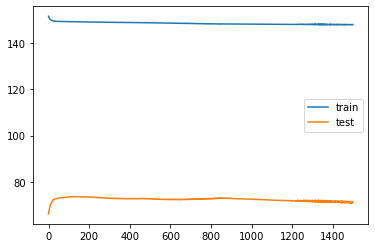

In [23]:
# LSTM model untuk residual
model2 = Sequential()
model2.add(LSTM(neuron_residual, input_shape=(residual_train_X.shape[1], residual_train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(residual_train_X, residual_train_y, epochs=epooch_residual, batch_size=size_batch, validation_data=(residual_test_X, residual_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat_residual = model2.predict(residual_test_X)
yhat_residual

array([[ -3.1515107],
       [ 29.444607 ],
       [ 29.387257 ],
       [-30.951258 ],
       [-36.067295 ],
       [ -5.33673  ],
       [ -4.536328 ],
       [-24.595804 ],
       [ -5.0071015],
       [ 28.291334 ]], dtype=float32)

In [25]:
# jadikan list semua hasil prediksi
residual_list = ndarray.tolist(yhat_residual)
seasonal_list = ndarray.tolist(yhat_seasonality)
ARIMA_list = hasil['predicted_mean'].tolist()
list_evaluasi = data_evaluasi['case'].tolist()
length = len(list_evaluasi)
hasil_final = list()

for i in range(length):
    residual_single = residual_list[i]
    seasonal_single = seasonal_list[i]
    residual_single = residual_single[0]
    seasonal_single = seasonal_single[0]
    tambah = residual_single+seasonal_single+ARIMA_list[i]
    hasil_final.append(tambah)
    #print('hasil tambah',tambah)

hasil_final

[734.6345714627702,
 689.5022700232907,
 855.0675245990228,
 821.1895324480039,
 829.1464756700716,
 739.651160989,
 612.901238811676,
 719.033774475383,
 660.8715618199152,
 859.7701924512182]

In [26]:
mse = mean_squared_error(list_evaluasi, hasil_final)
mse

18832.67183037255

In [27]:
rmse = mean_squared_error(list_evaluasi, hasil_final, squared=False)
rmse

137.23218219635126

In [28]:
mae = mean_absolute_error(list_evaluasi, hasil_final)
mae

117.47514961383995

<AxesSubplot:>

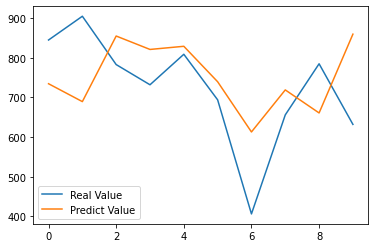

In [29]:
compare = pd.DataFrame(list(zip(list_evaluasi, hasil_final)), columns =['Real Value', 'Predict Value'])
compare.plot()